In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K

import SegDataGenerator_weight as gen
from util import plots, rgb2gray_all

# can't run on GPU
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_path = 'data/dataset_384x384.npz'
model_path = 'models/multi-unet/'
learning_rate = 0.0001
batch_size = 1
img_height = 384
img_width = 384
img_channel = 1
steps_per_epoch=500
epochs=50
validation_step=20
color_mode = 'grayscale'

In [3]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


In [4]:
def segmentation_loss_bk(y_true, y_pred):
    class_prop = 0.1638 
    weight_per_label = tf.scalar_mul(class_prop, tf.cast(tf.equal(y_true, 0), tf.float32)) + \
                        tf.scalar_mul(1.0 - class_prop, tf.cast(tf.equal(y_true, 1), tf.float32))
    cross_entropy = tf.losses.sigmoid_cross_entropy(y_true, y_pred)
    cross_entropy_weighted = tf.multiply(weight_per_label, cross_entropy)
    cross_entropy_mean = tf.reduce_mean(cross_entropy_weighted)
    return cross_entropy_mean

In [5]:
def segmentation_loss(y_true, y_pred):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true)

In [6]:
def contour_loss_bk(y_true, y_pred):
    class_prop = 0.2249
    weight_per_label = tf.scalar_mul(class_prop, tf.cast(tf.equal(y_true, 0), tf.float32)) + \
                        tf.scalar_mul(1.0 - class_prop, tf.cast(tf.equal(y_true, 1), tf.float32))
    cross_entropy = tf.losses.sigmoid_cross_entropy(y_true, y_pred)
    cross_entropy_weighted = tf.multiply(weight_per_label, cross_entropy)
    cross_entropy_mean = tf.reduce_mean(cross_entropy_weighted)
    return cross_entropy_mean

In [7]:
def contour_loss(y_true, y_pred):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true)

In [8]:
class Multi_UNet():
    def __init__(self, learning_rate, batch_size, img_height, img_width, img_channel):
        self.lr = learning_rate
        self.bs = batch_size
        self.height = img_height
        self.width = img_width
        self.channel = img_channel
        self.model = self.create_model()
    
    def ConvBlock(self, x, num_filter, conv_kernel_size=(3,3), dropout=0.2,
                  pool_size=(2,2), hasPool=True):
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                      kernel_initializer='he_normal', padding='same') (x)
        conv = Dropout(dropout) (conv)
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                      kernel_initializer='he_normal', padding='same') (conv)
        if hasPool == True:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        return conv
    
    def DeConvBlock(self, x, cat, num_filter=16, conv_kernel_size=(3,3), up_size=(2,2), 
                    up_stride=(2,2), dropout=0.2, axis=-1):
        deconv = Conv2DTranspose(num_filter, up_size, strides=up_stride, padding='same') (x)
        deconv = concatenate([deconv, cat], axis=axis)
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                      kernel_initializer='he_normal', padding='same') (deconv)
        conv = Dropout(dropout) (conv)
        conv = Conv2D(num_filter, conv_kernel_size, activation='elu', 
                    kernel_initializer='he_normal', padding='same') (conv)
        return conv
    
    
    def create_model(self):
        inputs = Input((self.height, self.width, self.channel,))
        
        # down-sampling
        conv1, pool1 = self.ConvBlock(inputs, 16, (3,3), 0.1, (2,2))
        conv2, pool2 = self.ConvBlock(pool1, 32, (3,3), 0.1, (2,2))
        conv3, pool3 = self.ConvBlock(pool2, 64, (3,3), 0.2, (2,2))
        conv4, pool4 = self.ConvBlock(pool3, 128, (3,3), 0.2, (2,2))
        conv5 = self.ConvBlock(pool4, 256, (3,3), 0.3, hasPool=False)
        
        # up-sampling
        conv6_s = self.DeConvBlock(conv5, conv4, 128, (3,3), (2,2), (2,2), 0.2)
        conv7_s = self.DeConvBlock(conv6_s, conv3, 64, (3,3), (2,2), (2,2), 0.2)
        conv8_s = self.DeConvBlock(conv7_s, conv2, 32, (3,3), (2,2), (2,2), 0.1)
        conv9_s = self.DeConvBlock(conv8_s, conv1, 16, (3,3), (2,2), (2,2), 0.1, axis=3)
        outputs_s = Conv2D(1, (1, 1), activation=None, name='segmentation') (conv9_s)
        
        conv6_c = self.DeConvBlock(conv5, conv4, 128, (3,3), (2,2), (2,2), 0.2)
        conv7_c = self.DeConvBlock(conv6_c, conv3, 64, (3,3), (2,2), (2,2), 0.2)
        conv8_c = self.DeConvBlock(conv7_c, conv2, 32, (3,3), (2,2), (2,2), 0.1)
        conv9_c = self.DeConvBlock(conv8_c, conv1, 16, (3,3), (2,2), (2,2), 0.1, axis=3)
        outputs_c = Conv2D(1, (1, 1), activation=None, name='contour') (conv9_c)
        
        model = Model(inputs=[inputs], outputs=[outputs_s, outputs_c])
        metrics = {'segmentation': [mean_iou], 'contour': [mean_iou]}
        loss = {'segmentation': segmentation_loss, 'contour': contour_loss}
        adam = optimizers.Adam(lr = self.lr)
        model.compile(optimizer=adam, loss=loss, loss_weights=[1.,1.], metrics=metrics)
        print(model.summary())
        
        return model


In [9]:
def evaluate(model):
    seg_thresh = 0.5
    contour_thresh = 0.4
    trainGenerator = gen.SegDataGenerator(validation_split=0.2)
    val_data = trainGenerator.flow_from_directory(data_path, subset='validation', batch_size=batch_size,
                                                   class_mode='segmentation', color_mode=color_mode,
                                                   use_contour=True)
    val_num = len(val_data)
    images = np.zeros((val_num, img_height, img_width, 3))
    masks_gt = np.zeros((val_num, img_height, img_width, 1))
    contours_gt = np.zeros((val_num, img_height, img_width, 1))
    masks_pred = masks_gt
    contours_pred = contours_gt
    for i in range(val_num):
        r = np.random.rand()
        image, label = next(val_data)
        seg_gt = label['segmentation']
        contour_gt = label['contour']
        prediction = model.predict(image, batch_size=1)
        seg_pred = K.eval(K.sigmoid(prediction[0]))
        contour_pred = K.eval(K.sigmoid(prediction[1]))
        images[i,:,:,:] = image
        masks_gt[i,:,:,:] = seg_gt
        masks_pred[i,:,:,:] = seg_pred
        contours_gt[i,:,:,:] = contour_gt
        contours_pred[i,:,:,:] = contour_pred        
        
        if r < 0.2:
            print("visualize batch " + str(i))       
            seg_pred_thresh = seg_pred > seg_thresh
            contour_pred_thresh = contour_pred > contour_thresh
            plots([image, seg_gt, contour_gt])
            plots([prediction[0], seg_pred_thresh, prediction[1], contour_pred_thresh])
    
    np.savez_compressed('data/validation_data.npz', images=images, masks_gt=masks_gt,
                       contours_gt=contours_gt, masks_pred=masks_pred, contours_pred=contours_pred)
        
    

In [15]:
def predict(model):
    print('start prediction')
    file = np.load(data_path)
#     file = np.load('data/test_data.npz')
    images = file['X_test']
    print(images.shape)
    images = rgb2gray_all(images)
    prediction = model.predict(images, batch_size=1)
    seg_pred = K.eval(K.sigmoid(prediction[0]))
    contour_pred = K.eval(K.sigmoid(prediction[1]))
    print(seg_pred.shape)
    np.savez_compressed('data/prediction_data.npz', images=images, masks=seg_pred, contours=contour_pred)
    
    test_num = images.shape[0]
    for i in range(test_num):
        image = images[i,:,:,:]
        image = np.expand_dims(image, axis=0)
        prediction = model.predict(image, batch_size=1)
        seg_pred = K.eval(K.sigmoid(prediction[0]))
        contour_pred = K.eval(K.sigmoid(prediction[1]))
        if i < 10:
            plots([image, seg_pred, contour_pred])
    
#    

In [11]:
def visualize(model):
    seg_thresh = 0.5
    contour_thresh = 0.4
    trainGenerator = gen.SegDataGenerator(validation_split=0.1)
    val_data = trainGenerator.flow_from_directory(data_path, subset='validation', batch_size=batch_size,
                                                   class_mode='segmentation', color_mode=color_mode,
                                                   use_contour=True)
    for i in range(20):
        r = np.random.rand()
        image, label = next(val_data)
        seg_gt = label['segmentation']
        contour_gt = label['contour']
        prediction = model.predict(image, batch_size=1)
        seg_pred = K.eval(K.sigmoid(prediction[0]))
        contour_pred = K.eval(K.sigmoid(prediction[1]))

        print("visualize batch " + str(i))
        seg_pred_thresh = seg_pred > seg_thresh
        contour_pred_thresh = contour_pred > contour_thresh
        plots([image, seg_gt, contour_gt])
        plots([prediction[0], seg_pred_thresh, prediction[1], contour_pred_thresh])
    

In [12]:
def main(args):
    TRAIN = False
    PREDICT = True
    # define model
    multi_unet = Multi_UNet(learning_rate, batch_size, img_height, img_width, img_channel)
    model = multi_unet.model
#     plot_model(model, to_file='model.png')
    print("generate model!")
    
    # define generator
    if TRAIN == True:
        trainGenerator = gen.SegDataGenerator(validation_split=0.1,
                                             horizontal_flip=True, vertical_flip=True,
                                            elastic_transform=True, rotation_range=50,
                                              zoom_range=0.2, width_shift_range=0.2,
                                              height_shift_range=0.2, fill_mode='reflect',
                                            samplewise_center=False, samplewise_std_normalization=False)
        train_data = trainGenerator.flow_from_directory(data_path, subset='training', batch_size=batch_size,
                                                       class_mode='segmentation', color_mode=color_mode,
                                                       use_contour=True, target_size=(img_height, img_width))
        val_data = trainGenerator.flow_from_directory(data_path, subset='validation', batch_size=batch_size,
                                                       class_mode='segmentation', color_mode=color_mode,
                                                       use_contour=True, target_size=(img_height, img_width))
        print("get data generator!")

        # training
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        checkpoint = ModelCheckpoint(model_path+'weight.{epoch:02d}.hdf5', monitor='val_loss',
                                     mode='min', period=1, save_best_only=False)

        print("start training!")
        model.fit_generator(train_data, steps_per_epoch=steps_per_epoch, epochs=epochs, 
                            callbacks=[checkpoint], validation_data=val_data, 
                            validation_steps=validation_step, shuffle=True)
        print("end training!")
        
    else:
        file_path = model_path + 'weight.50.hdf5'
        model.load_weights(file_path, by_name=False)
        print("load model!")
    
#     # start evaluation and visualization
#     if PREDICT == False:
#         evaluate(model)
#     # start prediction
#     else:
#         predict(model)
    return model
    

In [13]:
model = main(sys.argv)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 384, 384, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 384, 384, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 384, 384, 16) 2320        dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

start prediction
(65, 384, 384, 3)
(65, 384, 384, 1)


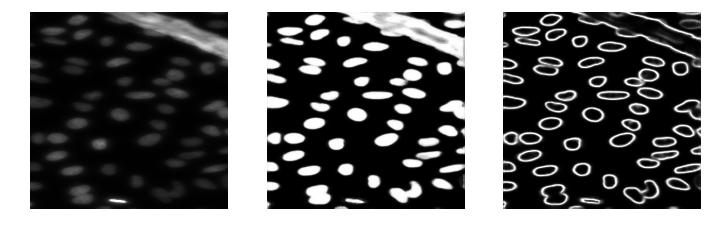

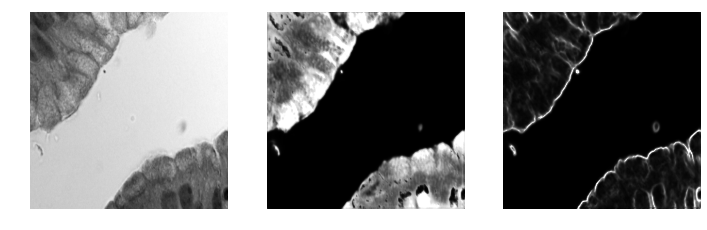

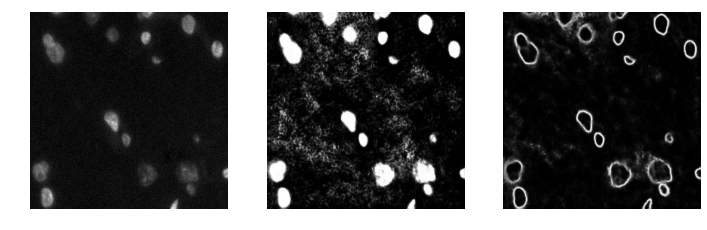

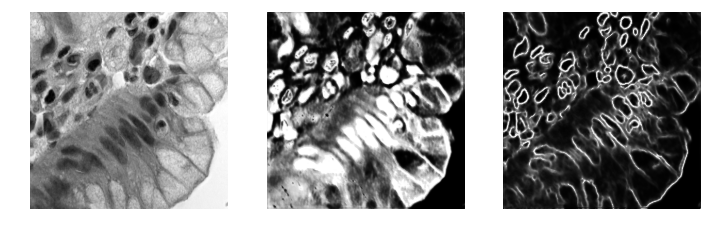

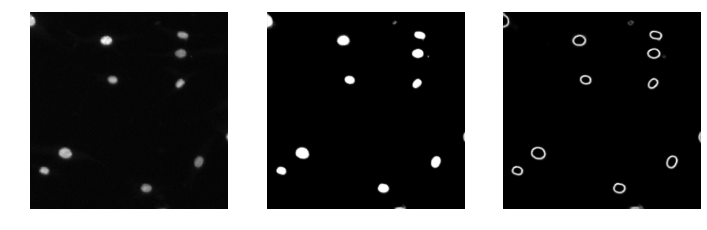

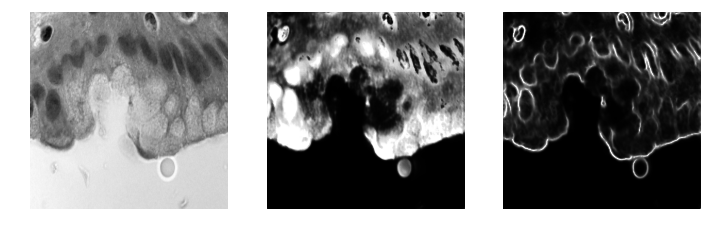

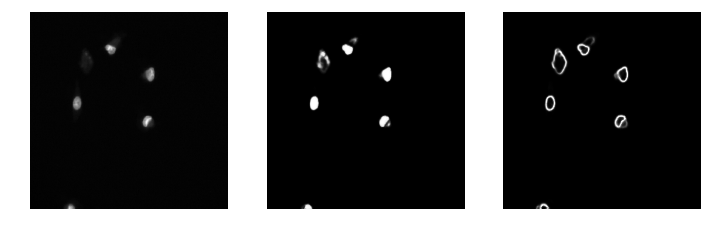

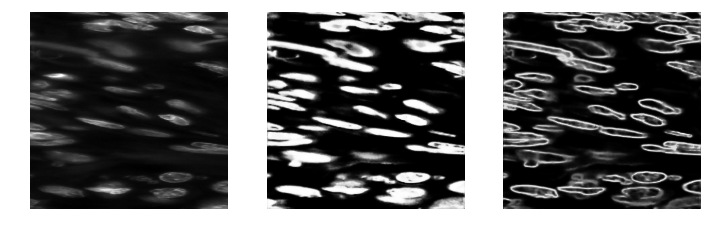

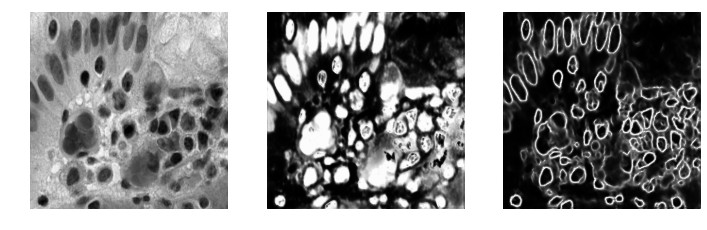

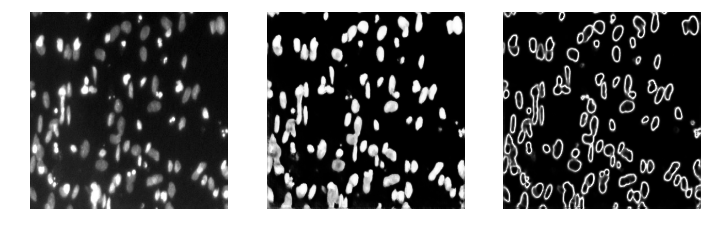

In [16]:
predict(model)